In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Palette
sns.set_palette("icefire")

# Load and Overview


In [ ]:
train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv", index_col=0)
test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv", index_col=0)
# orig = pd.read_csv("/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv")

for col in train.select_dtypes(include="object").columns:
            train[col] = train[col].astype("category")
for col in test.select_dtypes(include="object").columns:
            test[col] = test[col].astype("category")
    
print(
    "Missing Train: ",
    train.isnull().sum().sum(),
    " - Missing Test: ",
    test.isnull().sum().sum(),
    end="\n\n",
)
train.head(3)

Missing Train:  0  - Missing Test:  0



,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
id,,,,,,,,,,,,
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0


In [3]:
train.describe(include="all")

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994,593994,593994,593994,593994,593994,593994.000000
unique,NaN,NaN,NaN,NaN,NaN,3,4,5,5,8,30,NaN
top,NaN,NaN,NaN,NaN,NaN,Female,Single,Bachelor's,Employed,Debt consolidation,C3,NaN
freq,NaN,NaN,NaN,NaN,NaN,306175,288843,279606,450645,324695,58695,NaN
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,NaN,NaN,NaN,NaN,NaN,NaN,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,NaN,NaN,NaN,NaN,NaN,NaN,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


# Distribution

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   annual_income         593994 non-null  float64 
 1   debt_to_income_ratio  593994 non-null  float64 
 2   credit_score          593994 non-null  int64   
 3   loan_amount           593994 non-null  float64 
 4   interest_rate         593994 non-null  float64 
 5   gender                593994 non-null  category
 6   marital_status        593994 non-null  category
 7   education_level       593994 non-null  category
 8   employment_status     593994 non-null  category
 9   loan_purpose          593994 non-null  category
 10  grade_subgrade        593994 non-null  category
 11  loan_paid_back        593994 non-null  float64 
dtypes: category(6), float64(5), int64(1)
memory usage: 35.1 MB


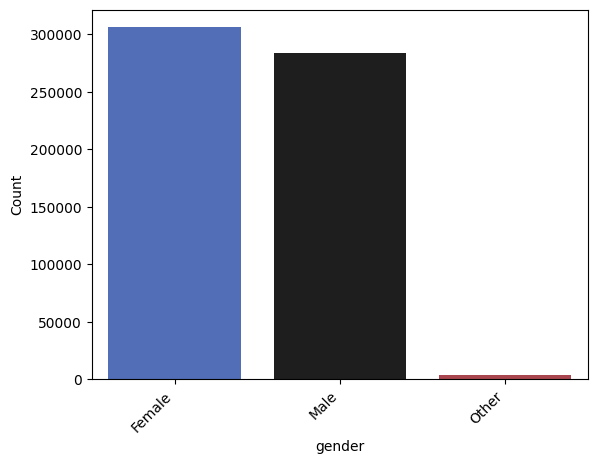

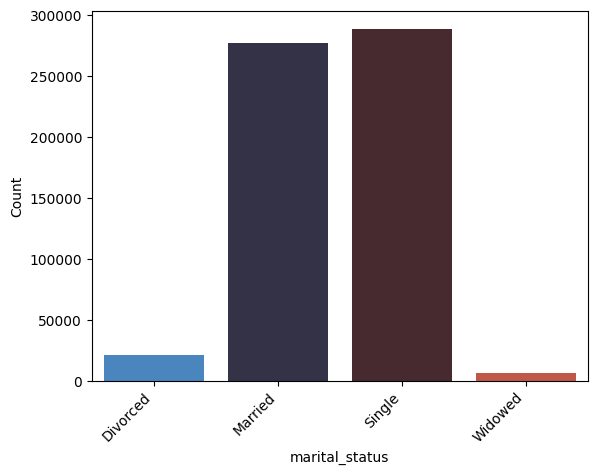

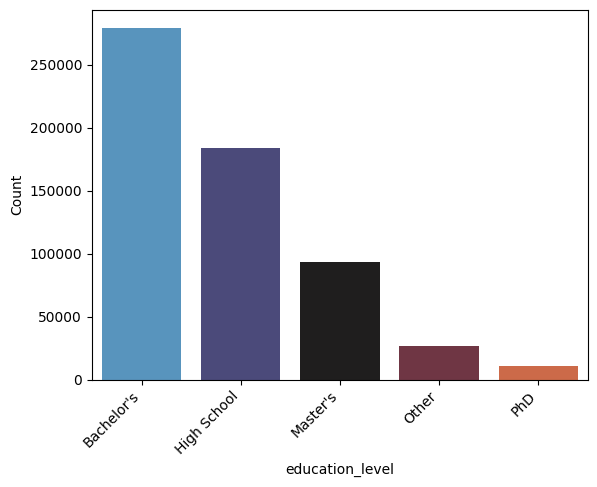

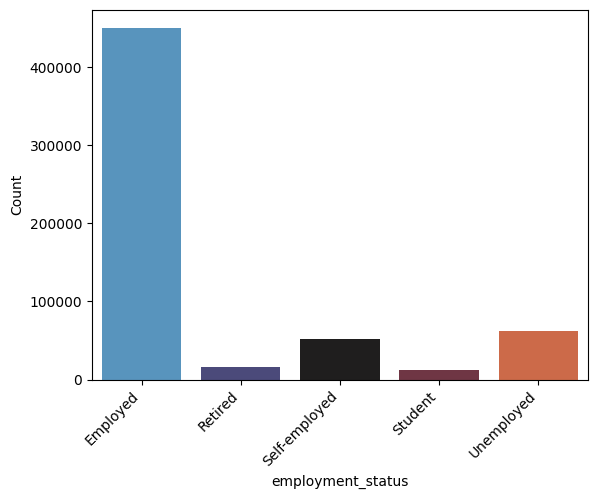

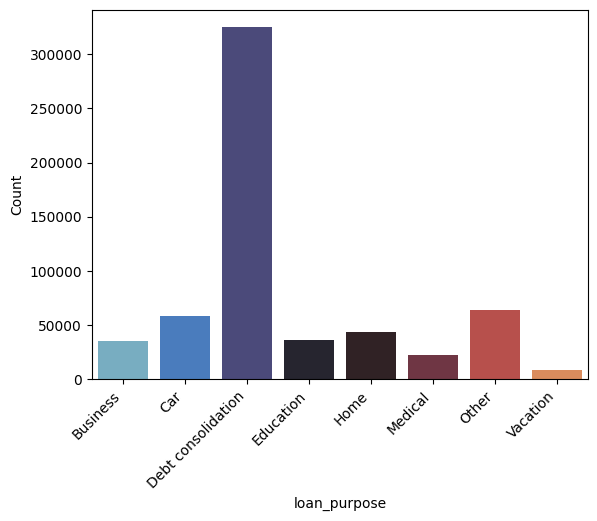

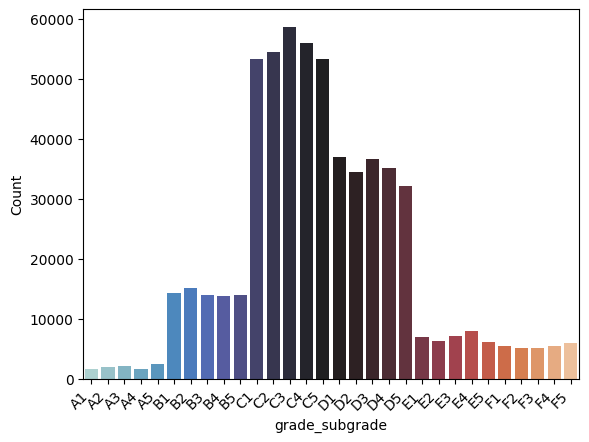

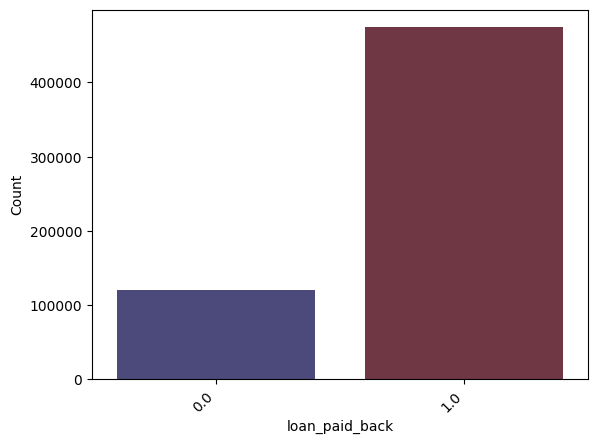

In [5]:
for col in train.select_dtypes(include="category").columns.to_list() + ["loan_paid_back"]:
    sns.countplot(data=train, x=train[col], palette="icefire")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [6]:
class Features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.risk = None

    def fit(self, df, y=None):
        df = df.copy()
        if isinstance(y, pd.Series):
            y = y.copy()
        else:
            y = pd.Series(data=y, index=df.index, name="y")

        if y is not None:
            df["loan_paid_back"] = y.values
            self.risk = df.groupby("employment_status")["loan_paid_back"].mean()

        self.debt_to_income_ratio_mean = df["debt_to_income_ratio"].mean()

        return self

    def transform(self, df):
        df = df.copy()

        df["annual_incomeXcredit_score"] = df["annual_income"] * df["credit_score"]
        df["loan_to_income"] = df["loan_amount"] / (df["annual_income"] + 1)
        df["interest_burden"] = (df["loan_amount"] * df["interest_rate"]) / (
            df["annual_income"] + 1
        )
        df["log_income"] = np.log1p(df["annual_income"])
        df["log_loan_amount"] = np.log1p(df["loan_amount"])

        df["debt_to_income_ratio_diff"] = (
            df["debt_to_income_ratio"] - self.debt_to_income_ratio_mean
        )
        df["debt_to_income_ratio_norm"] = (
            df["debt_to_income_ratio"] / self.debt_to_income_ratio_mean
        )

        if self.risk is not None:
            df["risk_map"] = df["employment_status"].map(self.risk).astype(float)

        df["credit_dti_interaction"] = df["credit_score"] / (
            df["debt_to_income_ratio"] + 1
        )
        df["income_dti_interaction"] = df["annual_income"] / (
            df["debt_to_income_ratio"] + 1
        )

        df = df.drop(
            [
                "loan_purpose",
                "gender",
                "education_level",
                "marital_status",
            ],
            axis=1,
        )

        return df

In [7]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]
X_pred = test

FeatureFrame = Features().fit_transform(X, y)
catFeatures = FeatureFrame.select_dtypes(include="category").columns.to_list()
numFeatures = FeatureFrame.select_dtypes(exclude="category").columns.to_list()

In [8]:
yn = y.to_numpy()
ys = pd.Series(data=yn, index=X.index, name="y")
ys

id
0         1.0
1         0.0
2         1.0
3         1.0
4         1.0
         ... 
593989    1.0
593990    1.0
593991    1.0
593992    1.0
593993    1.0
Name: y, Length: 593994, dtype: float64

In [9]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

xgb = Pipeline([
    ("feature", Features()),
    ("xgb",XGBClassifier(
        random_state=42,
        n_estimators=1500,
        learning_rate=0.03,
        enable_categorical=True,
        verbose=False,
        device="cuda",
        n_job=-1,
    )),
])

cat = Pipeline([
    ("feature", Features()),
    ("cat", CatBoostClassifier(
        random_state=42,
        n_estimators=1500,
        learning_rate=0.03,
        cat_features=catFeatures,
        verbose=False,
        task_type="GPU",
    )),
])

lgb = Pipeline([
    ("feature", Features()),
    ("lgb", LGBMClassifier(
        random_state=42, 
        n_estimators=1500, 
        learning_rate=0.03, 
        verbose=-1,
        device="gpu",
        n_job=-1,
    )),
])

In [10]:
score_xgb = cross_val_score(xgb, X, y, cv=cv, scoring="roc_auc")
print(
    f"xgb scores across folds: {score_xgb} - Mean Score: {score_xgb.mean():0.4f}"
)

score_cat = cross_val_score(cat, X, y, cv=cv, scoring="roc_auc")
print(
    f"cat scores across folds: {score_cat} - Mean Score: {score_cat.mean():0.4f}"
)

score_lgb = cross_val_score(lgb, X, y, cv=cv, scoring="roc_auc")
print(
    f"lgb scores across folds: {score_lgb} - Mean Score: {score_lgb.mean():0.4f}",
    end="\n\n",
)

score_xgb = np.mean([score_xgb, score_cat, score_lgb], axis=0)
print(f"Overall Performance: {score_xgb.mean()}")

xgb scores across folds: [0.92166308 0.92119852 0.91955485 0.92008857 0.919461  ] - Mean Score: 0.9204
cat scores across folds: [0.91974758 0.9190964  0.91789419 0.91837269 0.91782781] - Mean Score: 0.9186
lgb scores across folds: [0.92304858 0.92253497 0.92143782 0.92190527 0.92128911] - Mean Score: 0.9220

Overall Performance: 0.9203413639518152


In [11]:
total = score_xgb.mean() + score_cat.mean() + score_lgb.mean()
xgb_weight = score_xgb.mean() / total
cat_weight = score_cat.mean() / total
lgb_weight = score_lgb.mean() / total
print(xgb_weight, cat_weight, lgb_weight)

0.3333395921794947 0.33270444388318854 0.3339559639373168


In [12]:
xgb.fit(X, y)
cat.fit(X, y)
lgb.fit(X, y)

Pipeline(steps=[('feature', Features()),
                ('lgb',
                 LGBMClassifier(device='gpu', learning_rate=0.03,
                                n_estimators=1500, n_job=-1, random_state=42,
                                verbose=-1))])

In [13]:
importantFeatures = pd.DataFrame(
    data={
        "xgb": xgb.named_steps["xgb"].feature_importances_ / xgb.named_steps["xgb"].feature_importances_.max(),
        "cat": cat.named_steps["cat"].feature_importances_ / cat.named_steps["cat"].feature_importances_.max(),
        "lgb": lgb.named_steps["lgb"].feature_importances_ / lgb.named_steps["lgb"].feature_importances_.max(),
    },
    index = Features().fit_transform(X, y).columns
)
importantFeatures["Overall"] = importantFeatures.mean(axis=1)
importantFeatures = (importantFeatures.sort_values("Overall", ascending=False) * 100).round(2)
importantFeatures

,xgb,cat,lgb,Overall
risk_map,0.20,100.00,32.48,44.22
employment_status,100.00,16.09,1.40,39.17
credit_dti_interaction,11.63,21.29,83.29,38.74
credit_score,0.57,12.93,95.03,36.18
interest_rate,0.37,1.48,100.00,33.95
debt_to_income_ratio_diff,0.00,12.69,82.36,31.68
grade_subgrade,0.54,0.76,74.87,25.39
debt_to_income_ratio,2.91,4.42,65.30,24.21
debt_to_income_ratio_norm,0.00,8.74,53.97,20.90
interest_burden,0.36,0.37,52.22,17.65


In [14]:
xgb_pred = cross_val_predict(xgb, X, y, cv=cv, method="predict_proba")

In [15]:
treePredictions = pd.DataFrame(
    data={
        "xgbPrediction": cross_val_predict(xgb, X, y, cv=cv, method="predict_proba")[:,1],
        "catPrediction": cross_val_predict(cat, X, y, cv=cv, method="predict_proba")[:,1],
        "lgbPrediction": cross_val_predict(lgb, X, y, cv=cv, method="predict_proba")[:,1],
    },
    index=FeatureFrame.index,
)
treePredictions.head(10)

,xgbPrediction,catPrediction,lgbPrediction
id,,,
0,0.982866,0.982592,0.987050
1,0.550265,0.608717,0.536284
2,0.938321,0.938430,0.925096
3,0.857471,0.850589,0.843101
4,0.968576,0.962280,0.970828
5,0.951992,0.941546,0.953656
6,0.996955,0.993011,0.993569
7,0.892465,0.896900,0.925453
8,0.900877,0.951478,0.924510


In [17]:
treePredictions["WeightedPrediction"] = treePredictions["xgbPrediction"] * xgb_weight + treePredictions["catPrediction"] * cat_weight + treePredictions["lgbPrediction"] * lgb_weight
treePredictions.head(10)

,xgbPrediction,catPrediction,lgbPrediction,WeightedPrediction
id,,,,
0,0.982866,0.982592,0.987050,0.984172
1,0.550265,0.608717,0.536284,0.565043
2,0.938321,0.938430,0.925096,0.933941
3,0.857471,0.850589,0.843101,0.850382
4,0.968576,0.962280,0.970828,0.967234
5,0.951992,0.941546,0.953656,0.949072
6,0.996955,0.993011,0.993569,0.994512
7,0.892465,0.896900,0.925453,0.904957
8,0.900877,0.951478,0.924510,0.925604


In [24]:
ensemblePredictions = pd.DataFrame(
    data={
        "xgbPrediction": xgb.predict_proba(X_pred)[:,1],
        "catPrediction": cat.predict_proba(X_pred)[:,1],
        "lgbPrediction": lgb.predict_proba(X_pred)[:,1],
    },
    index=X_pred.index,
)
ensemblePredictions["Loan_paid_back"] = (ensemblePredictions["xgbPrediction"] * xgb_weight + ensemblePredictions["catPrediction"] * cat_weight + ensemblePredictions["lgbPrediction"] * lgb_weight).round(0)

In [ ]:
ensemblePredictions["Loan_paid_back"].to_csv("/kaggle/working" + "submission.csv")